Author: Ahmed Sobhi

Creation_date: 25th Jul 2023

Objective: Data Modeling

# Importing required libararies and packages

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np

# Used for visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

# For iteration visulization purpose
from tqdm import tqdm

# Import defined tools script
import sys

# adding tools script into system path
# sys.path.insert(0, '')
from tools import featureengineering, datapreprocessing, pipelinetransformers

# Used for datasplitting, modeling
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# To save the model locally
import joblib

ModuleNotFoundError: No module named 'sklearn'

# Data loading

In [4]:
# Loading raw dataset
df_raw = pd.read_csv('../data/raw/Inventory_data.csv')

df_raw.head()

,detailed_property_id,number_of_bedrooms,finishing_status,developer_name,compound_name,english_area_name,english_prop_type_name,unit_area,down_payment,time_to_delivery,offering_time
0,91856,3.0,Finished,AMD,FSAM,New Cairo,Apartment,250.0,0.0,282.0,10.0
1,85605,3.0,Finished,AMD,FSAM,New Cairo,Apartment,184.0,5.0,215.0,56.0
2,89162,3.0,Finished,TM,S,North Coast,Chalet,130.0,10.0,1469.0,27.0
3,89217,2.0,Finished,TM,S,North Coast,Chalet,95.0,10.0,1469.0,27.0
4,92340,3.0,Not Finished,TM,B,Mostakbal City,Apartment,160.0,5.0,1469.0,7.0


In [5]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
detailed_property_id,25731.0,52974.674595,23055.552421,275.0,32557.5,57331.0,71105.0,92543.0
number_of_bedrooms,25453.0,2.375869,1.279179,0.0,2.0,3.0,3.0,9.0
unit_area,25731.0,194.139715,1978.284904,7.0,110.0,156.0,200.0,120000.0
down_payment,25726.0,9.745364,7.605522,0.0,5.0,10.0,10.0,50.0
time_to_delivery,25731.0,570.310015,17624.242603,-728857.0,680.0,1134.0,1404.0,1982.0
offering_time,25731.0,105.016906,102.091937,2.0,23.0,70.0,160.0,533.0


# Train Test split

In [6]:
target_col = 'offering_time'

# Select features only
df_features = df_raw.drop(target_col, axis=1)

df_y = df_raw[target_col]

x_temp, x_test, y_temp, y_test = train_test_split(
    df_features,
    df_y,
    test_size=0.2,
    random_state=42,
    stratify=df_features['developer_name']
)

df_temp = pd.concat([x_temp, y_temp], axis=1)

# Apply data preprocessing
df_temp = datapreprocessing.data_preprocess(df_temp)

# Feature engineering
df_temp = featureengineering.feature_engineereing(df_temp)

x_temp = df_temp.drop(target_col, axis=1)
y_temp = df_temp[target_col]

x_train, x_val, y_train, y_val = train_test_split(
    x_temp,
    y_temp,
    test_size=0.2,
    random_state=42,
    stratify=x_temp['developer_name']
)

In [7]:
# Diplay shapes
print('Train set shape:', x_train.shape, y_train.shape)
print('Validation set shape:', x_val.shape, y_val.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Train set shape: (12451, 90) (12451,)
Validation set shape: (3113, 90) (3113,)
Test set shape: (5147, 10) (5147,)


# Preprocessing and Features Engineering

# Pipeline Steps

In [8]:
# Extract numerical|Categorical features
numeric_features = x_train.select_dtypes('number').columns.tolist()

categorical_features = x_train.select_dtypes('object').columns.tolist()

skewness_transformer = pipelinetransformers.SkewnessTransformer()

imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

numeric_transformer = Pipeline(
    [
        ('skewness', skewness_transformer),
        ('impute', imputer_numeric),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    [
        ('impute', imputer_categorical),
        ('ohc', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('numericals', numeric_transformer, numeric_features),
        ('Categorical', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    n_jobs=-1
)

In [9]:
# # # Testing
# preprocessor.fit(x_train)

# preprocessor.transform(x_train)

# Model Pipeline

In [12]:
initial_lr = 0.05

model = XGBRegressor(objective='reg:squarederror',
                     colsample_bytree=0.5,
                     learning_rate=initial_lr,
                     max_depth=6,
                     min_child_weight=1,
                     n_estimators=1000,
                     subsample=0.99,
                     verbosity=1,
                     n_jobs=-1)

XGB_param_grid = {
    'n_estimators': [500],
    'max_depth': [5],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_model = pipelinetransformers.GridSearchModel(model, XGB_param_grid)

model_pipeline = Pipeline(
    steps=[
        ('col_trans', preprocessor),
        ('model', model)
    ]
)

In [13]:
model_pipeline.fit(x_train, y_train) 

/home/yousri/Workspace/nawy_ds_assessment/nb_workspace/tools/pipelinetransformers.py:83: RuntimeWarning: divide by zero encountered in log1p
  transformed_log = np.log1p(feature)
/home/yousri/anaconda3/envs/realstate/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1070: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/home/yousri/Workspace/nawy_ds_assessment/nb_workspace/tools/pipelinetransformers.py:94: RuntimeWarning: invalid value encountered in sqrt
  transformed_sqrt = np.sqrt(feature)


{'No Fix': [2, 3, 4, 5, 6, 7, 8, 10, 15, 16, 21, 24, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 82]}


Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numericals',
                                                  Pipeline(steps=[('skewness',
                                                                   SkewnessTransformer()),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['number_of_bedrooms',
                                                   'unit_area', 'down_payment',
                                                   'time_to_delivery',
                                                   'nbedrooms_per_area',
                                                   'downpayment_per_delivery_time',
                                                   'deliverytime_per_area',
                                                   'Apartment_d...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=1000, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

# Saving the model

In [17]:
# Save the model
if not os.path.exists('../src/model/'):
        os.makedirs('../src/model/')

joblib.dump(model_pipeline, f'../src/model/xgboost_model.pkl')

['../src/model/xgboost_model.pkl']

# Loading the model

In [18]:
# Load the model
model_load = joblib.load(f'../src/model/xgboost_model.pkl')

# Evaulating: Validation set

In [19]:
pred_train = model_load.predict(x_train).round()

pred_val = model_load.predict(x_val).round()

In [20]:
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

rmse_val = mean_squared_error(y_val, pred_val, squared=False)

print(f"RMSE:\n\tTrain Set = {rmse_train}\n\tVal Set = {rmse_val}")

RMSE:
	Train Set = 35.07688699077753
	Val Set = 48.0547691871667


Notes to be considered for more improvement:
- There are negative values in the prediction model, should be first treated to be at least be zeros.
- During the feature engineering, during calculation the average time_to_delivery per property, there were missing values, which should be imputed.
  - For the current time, it was imputed with -1, which is not accurate, but also can't be filled with zeros.
  - The correct way is to fit linear regressor model, to calculate the appropriate values for the missing values.


Notes Metric for business:
- As we are dealing with Regression problem, we don't have such Accuracy metric, So Depending on Bussiness, An accuracy metric could be defined as measurable & understandable method.

- A suggested accuracy metric, is depending on relative features, we could calculate the [mean, standard deviation] as a margin for each offering time. So this problem would be converted into classification of whether the prediction are within the margin of true values or not.

In [21]:
# Defined business metric
margin_effect_cols = ['english_prop_type_name', 'developer_name']
df_margin = df_raw.groupby(margin_effect_cols, as_index=False).agg(margin_avg=('offering_time', 'mean'), margin_std=('offering_time', 'std'))

df_margin

,english_prop_type_name,developer_name,margin_avg,margin_std
0,Apartment,A(AMG),52.909091,3.503245
1,Apartment,AASD,43.754808,35.709543
2,Apartment,AD,184.264000,136.420278
3,Apartment,AH,224.963636,118.995176
4,Apartment,AMD,25.279070,32.085605
...,...,...,...,...
272,Villa,P&P,14.200000,16.791532
273,Villa,PHD,74.913767,93.028605
274,Villa,S,126.841808,85.790097
275,Villa,TM,126.654321,100.779234


In [22]:
x_train['pred'] = pred_train
x_train['y_true'] = y_train
df_train = x_train.merge(df_margin, how='left', on=margin_effect_cols)

acc = (abs(df_train.pred - df_train.y_true) < df_train.margin_std).sum()/df_train.shape[0]
acc 

0.9404867078949481

In [23]:
df_train['pred'].describe()

count    12451.000000
mean        88.285278
std         69.088341
min        -11.000000
25%         35.000000
50%         68.000000
75%        122.000000
max        356.000000
Name: pred, dtype: float64

# Feature Importance

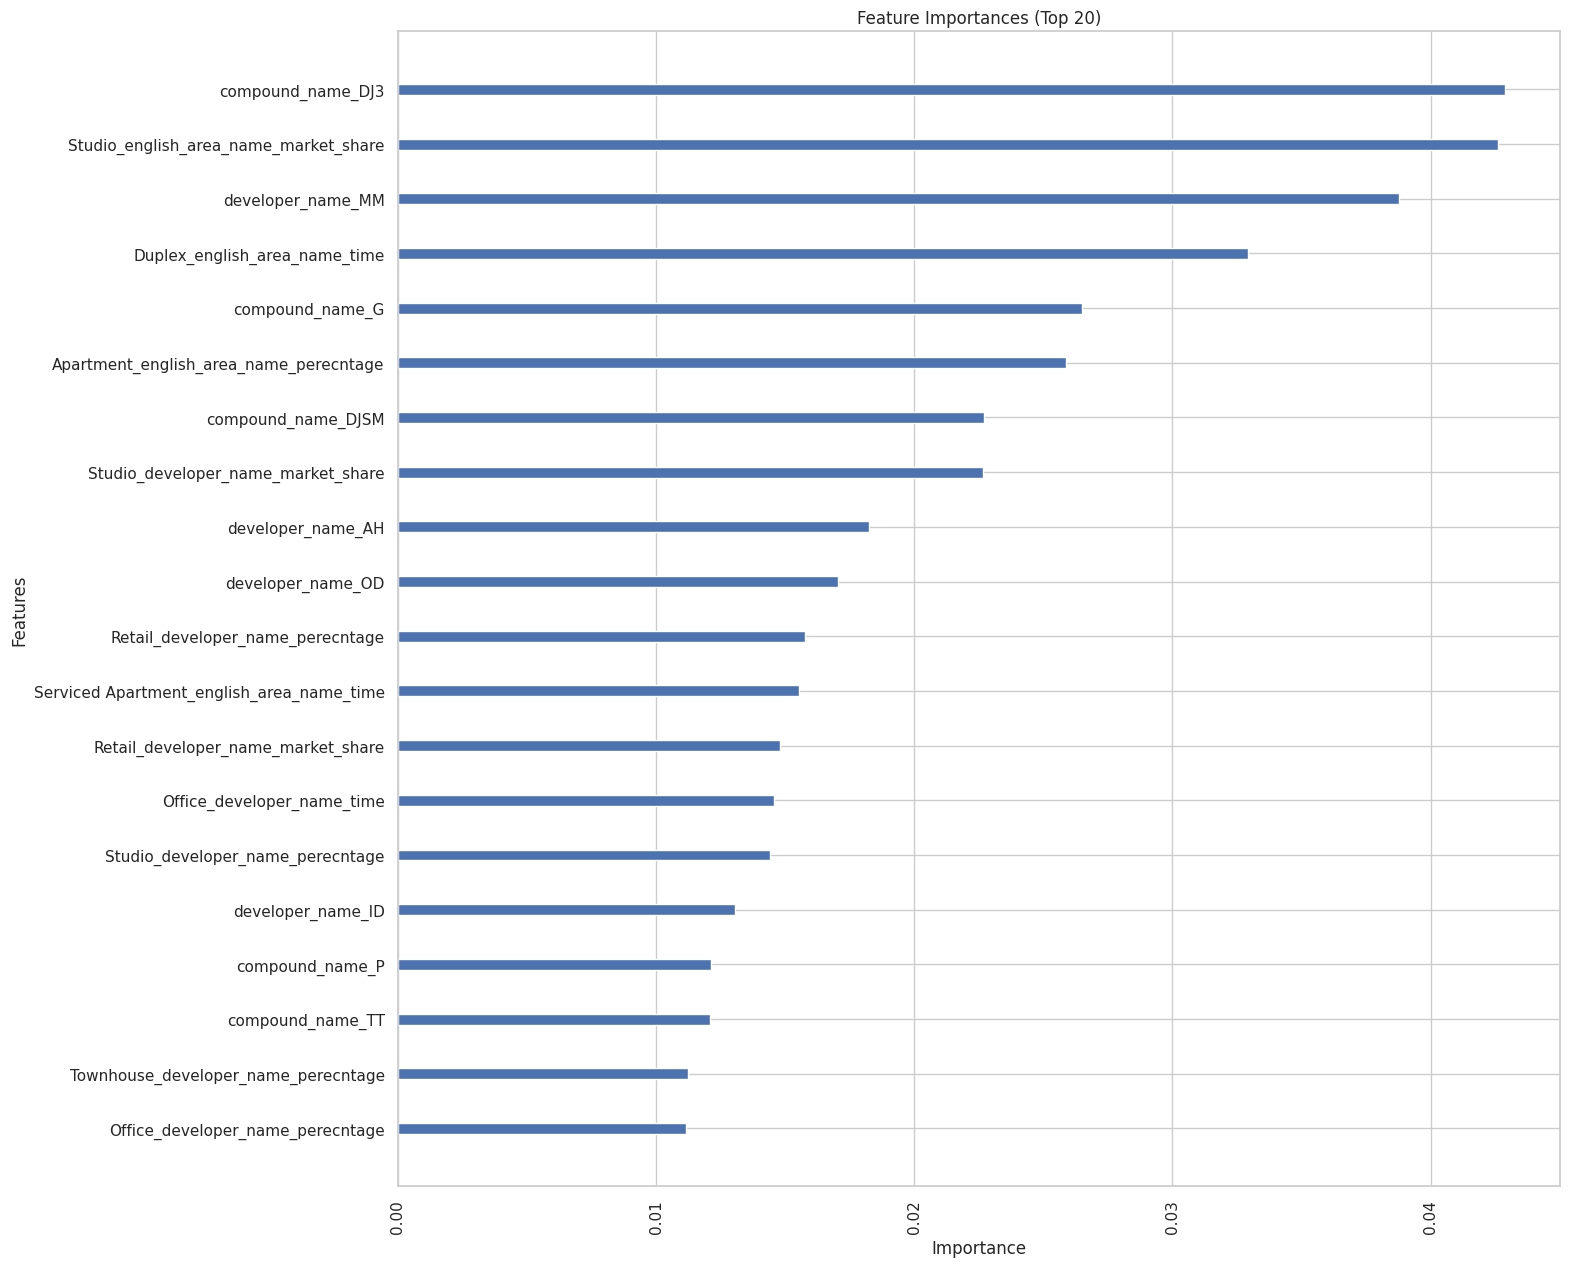

In [24]:
# Get features importances
features_importances = model_load.named_steps['model'].feature_importances_

# Get the ColumnTransformer step
column_transformer = model_load.named_steps['col_trans']

# Get the numerical feature names
numerical_features = column_transformer.transformers_[0][2]

# Get the one-hot encoded feature names
one_hot_encoder = column_transformer.named_transformers_['Categorical'].named_steps['ohc']
categorical_features = one_hot_encoder.get_feature_names_out(column_transformer.transformers_[1][2])

# Combine feature names and importances
feature_names = np.concatenate((numerical_features, categorical_features))
importances = np.concatenate((features_importances[:len(numerical_features)], features_importances[len(numerical_features):]))

importances, feature_names = zip(*sorted(zip(importances, feature_names)))

# Plot the feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_names[-20:], importances[-20:], height=0.2)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importances (Top 20)')
plt.xticks(rotation=90)
plt.savefig('../report/plots/feature_importance_v0.png', bbox_inches='tight')
plt.show()

In [25]:
df_features_import = pd.DataFrame({'feature':feature_names, 'importance':importances})
df_features_import = df_features_import.sort_values('importance', ascending=False)
df_features_import.head(20)

,feature,importance
318,compound_name_DJ3,0.042880
317,Studio_english_area_name_market_share,0.042591
316,developer_name_MM,0.038782
315,Duplex_english_area_name_time,0.032921
314,compound_name_G,0.026514
313,Apartment_english_area_name_perecntage,0.025873
312,compound_name_DJSM,0.022717
311,Studio_developer_name_market_share,0.022677
310,developer_name_AH,0.018242
309,developer_name_OD,0.017037


In [26]:
df_features_import.to_csv(f'../data/output/feature_importance.csv', index=False)